In game Win Probability Modelling:
============================================
Part 2 : Exploratory Data Analysis
---------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn import preprocessing
from ggplot import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Setting display priorities, might cause security issues because of the raw html injection !
from IPython.core.display import display, HTML
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
display(HTML("<style>.container { width:80% !important; }</style>")) # uncomment for security issues
np.set_printoptions(precision=4)
pd.set_option('display.max_columns',50)

In [3]:
data_clean = pd.read_csv("data_clean.csv", index_col = None)
data_clean.drop(labels=['Unnamed: 0', 'sequence_id'], axis=1, inplace=True)
data_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
data_clean.fillna(value=0, inplace=True)

In [4]:
data_model = data_model = data_clean.drop(labels=['period', 'play_clock', 'home_description', 'away_description', 'score', 'player1_id', 'player1_name', 'player1_team', 'player2_id', 'player2_name', 'player2_team', 'player3_id', 'player3_name','player3_team', 'event_type', 'home', 'away', 'event_description'], axis=1)

Histogram plot
---------------
Most of the pre season features are normally distributed whereas the in game features are skewed to the right. The target variable is unbalanced.
We have more 2015 games than 2016 games.

In [5]:
data_model.columns

Index(['game_id', 'remaining_time', 'score_difference',
       'score_diff_percentile', 'home_result', 'in_violations', 'in_rebound',
       'in_hfouls', 'in_hshoot_fouls', 'in_afouls', 'in_ashoot_fouls',
       'in_turnover', 'in_shot_accuracy', 'in_ft_accuracy', 'in_momentum',
       'total_win_ratio', 'home_away_win_ratio', 'nth_game_season', 'pre_PACE',
       'pre_AST', 'pre_TO', 'pre_ORR', 'pre_DRR', 'pre_EFF_FG', 'pre_TS',
       'pre_OFF_EFF', 'pre_DEF_EFF', 'home_rank', 'away_rank'],
      dtype='object')

C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


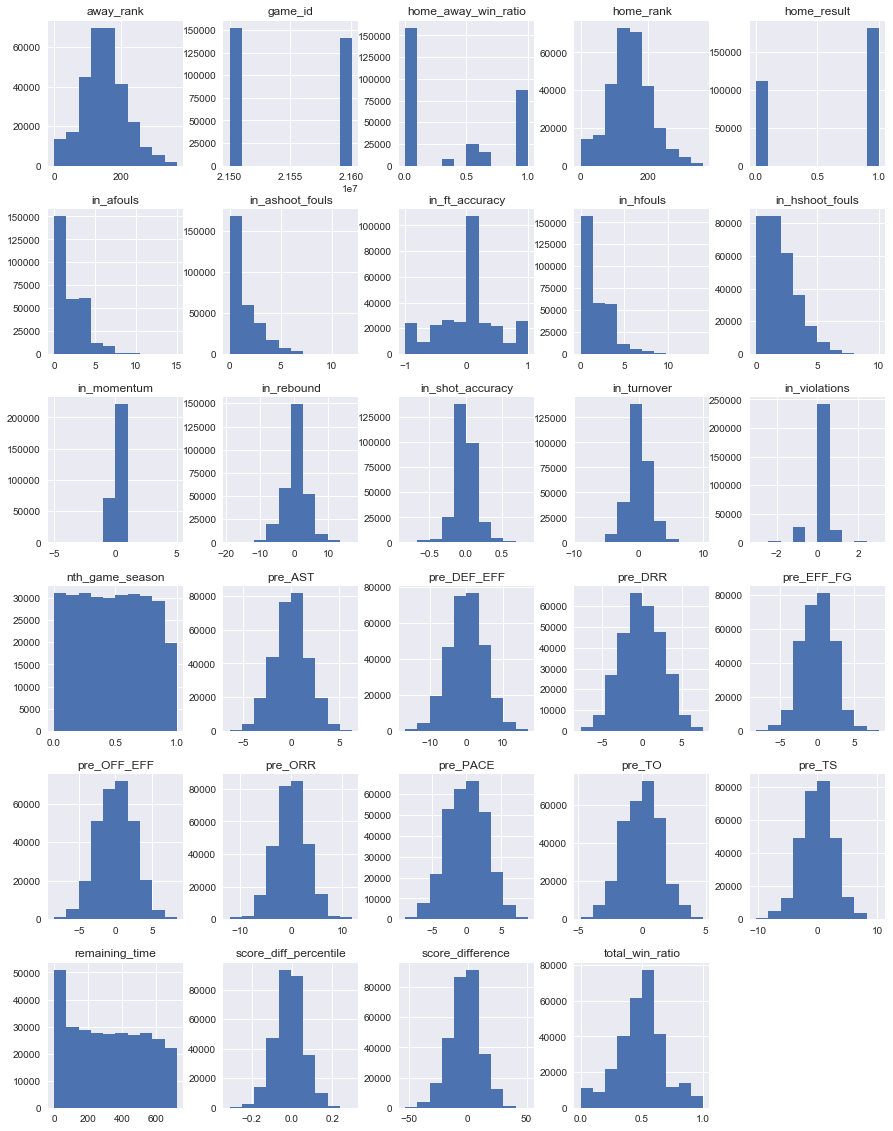

In [6]:
# Drawing histogram on all the features
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
hist = data_model.hist(ax = ax)
plt.show()

Correlation plot
-----------------
The target variable home_result is correlated positively with previous season's  
True shooting percentage, Offensive and defensive efficiency and Assist ratio. Also positively correlated with total win's this season. It is weakly correlated with total rebounds in the current game, and shot and free throw accuracy which is expected. It is negatively correlated with score_difference as expected as well.

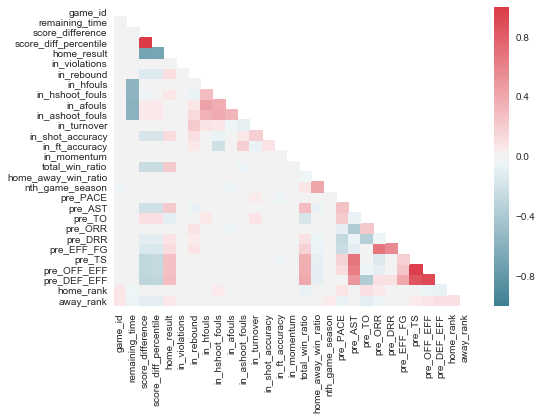

In [7]:
# Correlation matrix plot
correlation = data_model.corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")
heatmap = sns.heatmap(correlation, cmap=cmap, mask=mask)
plt.figure(figsize=(11,9))
plt.show()

In [8]:
bins = list(range(0, 120, 12)) + list(range(120, 721, 24))
binned_df = pd.DataFrame(pd.cut(data_model['remaining_time'], bins, include_lowest=True))
binned_df.reset_index(inplace=True)

data_model['time_bracket'] = pd.Series(dtype='object')
data_model.time_bracket = binned_df.remaining_time

strat_sample = data_model.groupby(['game_id', 'time_bracket']).apply(lambda x: x.sample(min(len(x), 1)))
strat_sample.reset_index(drop=True, inplace=True)

strat_sample.drop(labels=['time_bracket'], axis=1, inplace=True)
data_model.drop(labels=['time_bracket'], axis=1, inplace=True)
strat_sample = strat_sample.sample(n=strat_sample.shape[0])
bkp_strat = strat_sample.copy()

In [9]:
pca_df = strat_sample[strat_sample.columns.difference(['home_result'])]
std_scale = preprocessing.StandardScaler().fit(pca_df)
pca_df = std_scale.transform(pca_df)

pca = PCA(n_components=2)
pca_df = pca.fit(pca_df).transform(pca_df)



In [10]:
print("Variance explained by the first two pc axes {}".format(pca.explained_variance_ratio_))
pca_df.shape

Variance explained by the first two pc axes [ 0.1461  0.1005]


(78661, 2)

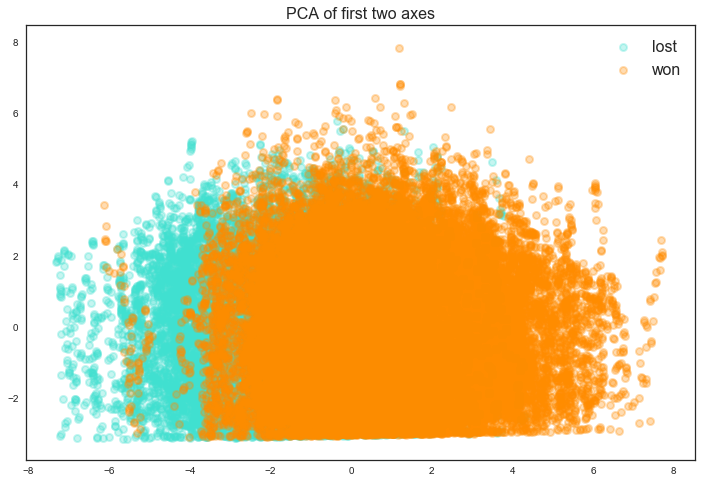

In [11]:
plt.figure(figsize=(12,8))
colors = ['turquoise', 'darkorange']
lw = 2
target_names = ['lost','won']
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(pca_df[strat_sample['home_result'] == i, 0], pca_df[strat_sample['home_result'] == i, 1], color=color, alpha=.3, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize=16)
plt.title('PCA of first two axes',fontSize=16)

plt.figure(figsize=(15, 10))
plt.show()